In [1]:
import os
import numpy as np
import pandas as pd
from astropy.time import Time, TimeDelta
import astropy.units as u
# Use Observer to find sunset/sunrise .. not strictly necessary
from astroplan import Observer

import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML

from rubin_sim.phot_utils import predicted_zeropoint

Get visit information, however is appropriate for your needs. 
We need things that are in the consdb, but my understanding is that these are also in visit_summary_table or maybe even just visit_table (I'd appreciate some pointers here, so I can also retrieve these things from nightlyValidation runs). 
The consdb contents come from RapidAnalysis outputs. 

The things needed for comparison are: 
* airmass (consdb) airmass (visit_summary)
* shut_time (consdb) shutTime? (visit_summary) -- the open shutter time for the exposure
* zero_point_median (consdb) zeroPointMedian (maybe? visit_summary)
* eff_time_zero_point_scale_median (consdb) effTimeZeroPointScaledMedian (visit_summary)

.. note that you could use per-detector values (without _median/Median) if you wanted, but I figured I trusted Merlin/RA to do that median calculation with appropriate rejection

Also, I'm only going to pull information for one night at a time, during nighttime .. obviously you could just do whole dayobs (and afterwards reject nonsense) or multiple nights, but this seems a reasonable demo.

In [ ]:
# I'm going to fetch this from the consdb here -- 
# you could use ConsdbClient (stack dependent) or query the FastAPI or TAP (implemented in rubin_nights, not stack dependent so just pip installable)
# or if you're getting from butler, do the butler magic.

#!pip install --user --upgrade git+https://github.com/lsst-sims/rubin_nights.git  --no-deps  > /dev/null 2>&1
from rubin_nights.connections import get_clients
import logging
logging.getLogger('rubin_nights').setLevel(logging.INFO)

if os.getenv("EXTERNAL_INSTANCE_URL") is None:
    tokenfile = '/Users/lynnej/.lsst/usdf_rsp'
    site = 'usdf'
    endpoints = connections.get_clients(tokenfile=tokenfile, site=site)
else:
    tokenfile = None
    site = None
    endpoints = connections.get_clients()

# For easier visualization, just one night and only night time
day_obs = '2025-05-28'
day_obs_time = Time(f"{day_obs}T12:00:00", format='isot', scale='tai')
observer = Observer.at_site('lsst')
sunset = Time(observer.sun_set_time(day_obs_time, which='next', horizon=-10*u.deg), format='jd')
sunrise = Time(observer.sun_rise_time(day_obs_time, which='next', horizon=-10*u.deg), format='jd')

print(f"Checking night time on {day_obs}, from {sunset.iso} to {sunrise.iso}")
print(f"Time of notebook execution {Time.now().iso}")

query = f"select v.*, q.* from cdb_lsstcam.visit1 as v left join cdb_lsstcam.visit1_quicklook as q on v.visit_id = q.visit_id where obs_start_mjd >= {sunset.mjd} and obs_start_mjd <= {sunrise.mjd} and img_type not in ('BIAS', 'FLAT')"
visits = endpoints['consdb'].query(query)

print(f"Retrieve {len(visits)} visits from consdb")

Ok, so with that information in hand ..  (here, as a pandas DataFrame)

In [ ]:
# You can calculate predicted zeropoint for the given exposure time, or for the scaled to 1s exposure time
# both here .. just because
def calculate_predicted_zeropoint(x):
    if x.shut_time == 0 or np.isnan(x.shut_time):
        x.zero_point_predicted = np.nan
    else:
        x.zero_point_predicted = predicted_zeropoint(x.band, x.airmass, x.shut_time)
        x.zero_point_1s = x.zero_point_median - 2.5 * np.log10(x.shut_time)
        x.zero_point_1s_pred = (
            predicted_zeropoint(x.band, x.airmass, 1) 
        )
    x.zp_offset = x.zero_point_median - x.zero_point_predicted
    return x

new_cols = ['zero_point_predicted', 'zero_point_1s', 'zero_point_1s_pred', 'zp_offset']
new_df = pd.DataFrame(np.zeros((len(visits), len(new_cols))), columns=new_cols)
visits = pd.merge(left=visits, right=new_df, left_index=True, right_index=True)
visits = visits.apply(calculate_predicted_zeropoint, axis=1)

In [ ]:
cols = ['visit_id', 'band', 'obs_start', 'obs_end', 'shut_time', 's_ra', 's_dec', 'sky_rotation', 'airmass', 'zero_point_median', 'eff_time_zero_point_scale_median', 'zero_point_predicted', 'zp_offset', 'img_type', 'target_name', 'science_program']
#visits[cols]

So now let's just compare looking at the effective time zeropoint scale and the zeropoint offset between predicted and measured (note that both of these have as part of the calculation the measured zeropoint, so in places where the reference catalog is bad - thus making the measured zeropoint bad - they will fail in similar ways).

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 14), sharex=True)
datetimes = Time(visits.exp_midpt_mjd, format='mjd', scale='tai').utc.to_datetime()
visits['datetime'] = datetimes
ax = axes[0]
for sp in visits.science_program.unique():
    q = visits.query("science_program == @sp")
    ax.plot(q.datetime, q.airmass, 
            marker='.', linestyle='', label=sp)
ax.legend(loc=(1.01, 0.5))
ax.grid(alpha=0.3)
ax.set_ylim(0.95)
ax.invert_yaxis()
ax.set_ylabel("Airmass")

ax = axes[1]
for sp in visits.science_program.unique():
    q = visits.query("science_program == @sp")
    ax.plot(q.datetime, q.eff_time_zero_point_scale_median, 
            marker='.', linestyle='', label=sp)
ax.legend(loc=(1.01, 0.5))
ax.grid(alpha=0.3)
#ax.axhline(0.6, color='b', linestyle=':')
ax.set_ylabel("EffTimeZeropointScaled")

ax = axes[2]
for sp in visits.science_program.unique():
    q = visits.query("science_program == @sp")
    ax.plot(q.datetime, q.zp_offset,
            marker='.', linestyle='', label=sp)
#ax.axhline(-1.5, color='r', linestyle=':')
ax.grid(alpha=0.3)
ax.set_ylabel("Zeropoint Offset (~mag cloud extinction)")
ax.set_xlabel("Exposure Midpoint (UTC)")
ax.tick_params("x", rotation=90)
ax.legend(loc=(1.01, 0.5))

axes[0].set_title(f"DayObs {day_obs}")
plt.subplots_adjust(wspace=0, hspace=0)

Text(0.5, 0, 'Airmass')

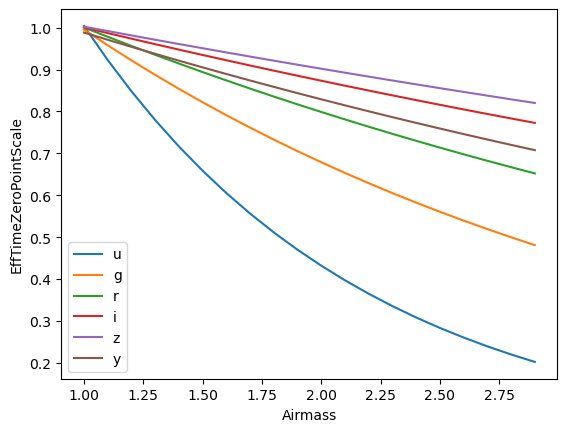

In [3]:
airmass = np.arange(1, 3, 0.1)

# From obs_lsst
fiducialZeroPoint = {
     "u": 26.52,
     "g": 28.51,
     "r": 28.36,
     "i": 28.17,
     "z": 27.78,
     "y": 26.82,
 }

# Calculation of effTimeZeroPointScale  is 
# zeroPointDiff = fiducialZeroPoint - (summary.zeroPoint - 2.5*np.log10(exposureTime))
# c_eff = min(10**(-2.0*(zeroPointDiff)/2.5), np.inf ) # might be 1 instead of np.inf

plt.figure()
# So let's see what a good night (no extinction) would look like at a range of airmasses
for b in 'ugrizy':
    best_zp = predicted_zeropoint(b, airmass, 30)
    zp_diff = fiducialZeroPoint[b] - best_zp + 2.5*np.log10(30)
    efftime = 10**(-2.0 * zp_diff / 2.5)
    plt.plot(airmass, efftime, label=b)
plt.legend()
plt.ylabel("EffTimeZeroPointScale")
plt.xlabel("Airmass")